In [24]:
import pickle

res = []

In [30]:




with open("/home/mgorski/mglab/data/ffs_wyniki_1055.pkl", "rb") as f:
    res_tmp = pickle.load(f)

res.extend(res_tmp)

In [31]:
for r in res[:1]:
    print(r.keys())
    print(r["stats"].keys())
    print(r["segments"].keys())
    print(r["stats"]["stars"].keys())


dict_keys(['name', 'hdr', 'stats', 'segments', 'sun_sep', 'moon_sep', 'sun_alt', 'moon_alt', 'moon_ph'])
dict_keys(['min', 'max', 'mean', 'median', 'rms', 'q_sigma_lower', 'q_sigma_upper', 'q_sigma', 'noise', 'bkg_max_amplitude', 'bkg_frame_gradient', 'sky_surface_coeff', 'sky', 'stars', 'lines'])
dict_keys(['diff_n_stars', 'diff_fwhm', 'diff_ell', 'diff_nc'])
dict_keys(['x', 'y', 'max_adu', 'fwhm_x', 'fwhm_y', 'ellipticity', 'theta', 'cpe'])


In [101]:
# konfiguracja schema

def normalize_header(header):
    out = dict(header)

    for k, v in out.items():
        if isinstance(v, str):
            out[k] = v.strip()
        if v == 'T':
            out[k] = True
        if v == 'F':
            out[k] = False

    return out

SCIENCE_SCHEMA = {
    "$schema": "http://json-schema.org/draft-07/schema#",
    "type": "object",
    "required": [
        "IMAGETYP",
        "MIRR-COV",
        "DOME-SHT",
        "ALT_TEL",
        "EXPTIME",
        "T-CAM",
        "T-CAMSET",
        "TRACKING",
        "RHUM-WS",
        "T-WS",
        "WIND-AVG"
    ],
    "properties": {
        "IMAGETYP": {
            "type": "string",
            "enum": ["science"]
        },

        "MIRR-COV": {
            "type": "integer",
            "enum": [3]                 # open
        },

        "DOME-SHT": {
            "type": "integer",
            "enum": [0, 2]              # open / opening
        },

        "ALT_TEL": {
            "type": "number",
            "minimum": 33
        },

        "EXPTIME": {
            "type": "number",
            "exclusiveMinimum": 0.5
        },

        "T-CAM": {
            "type": "number",
            "maximum": -58
        },

        "T-CAMSET": {
            "type": "number",
            "enum": [-60.0]
        },

        "READ-MOD": {
            "type": "integer",
            "const": 2
        },

        "GAIN-MOD": {
            "type": "integer",
            "const": 2
        },

        "TRACKING": {
            "type": "boolean",
            "const": True
        },

        "FAN-MIRR": {
            "type": "boolean",
            "const": False
        },

        "FAN-DOME": {
            "type": "boolean",
            "const": False
        },

        "RHUM-WS": {
            "type": "number",
            "maximum": 75
        },

        "T-WS": {
            "type": "number",
            "minimum": 0
        },

        "WIND-AVG": {
            "type": "number",
            "maximum": 15
        }
    },

    "additionalProperties": True
}




In [103]:
# General Filter

saturation = 40000

from jsonschema import validate, ValidationError, Draft7Validator
import numpy as np


for r in res:
    objects_2_ignore = ["NGC2362"]

    if r["hdr"]["OBJECT"] not in objects_2_ignore:

        f = r["name"]

        sc = f+" "
        dqc = False
        txt = ""



        # header
        hdr = normalize_header(r["hdr"])

        validator = Draft7Validator(SCIENCE_SCHEMA)
        for err in validator.iter_errors(hdr):
            dqc = True
            sc = sc + "❌"
            txt = txt + f'❌ {list(err.path)} : {err.message} \n'


        # LINIE

        c = r["stats"]["lines"]["val"]

        if len(c)>0:
            c = c[0]
            if c > 500:
                dqc = True
                sc = sc + "*"
                txt = txt + f'* LINE detected {c} \n'

        # GRADIENT
        c = r["stats"]["bkg_frame_gradient"]
        if c > 100:
            dqc = True
            sc = sc + "*"
            txt = txt + f'* FRAME GRADIENT detected {c} \n'
        c = r["stats"]["bkg_max_amplitude"]
        if c > 100:
            dqc = True
            sc = sc + "*"
            txt = txt + f'* LARGE SKY BACKGROUND CHANGES detected {c} \n'

        # czy sa gwiazdy
        stars = r["stats"]["stars"]
        mk = stars["max_adu"] < saturation

        c = len(np.array(stars["x"])[mk])
        if c < 5:
            dqc = True
            sc = sc + "#"
            txt = txt + f'# NO STARS detected {c} \n'
        else:
            # FWHM
            if "fwhm_x" in stars.keys():
                if len(np.array(stars["fwhm_x"])[mk]) < 10:
                    dqc = True
                    sc = sc + "#"
                    txt = txt + f'# NO FWHM measured {c} \n'
                else:
                    fx = np.nanmedian(np.array(stars["fwhm_x"])[mk])
                    fy = np.nanmedian(np.array(stars["fwhm_y"])[mk])
                    if np.isnan(fx) or np.isnan(fy):
                        dqc = True
                        sc = sc + "*"
                        txt = txt + f'* FWHM: {fx} {fy} \n'
                    else:
                        fwhm = fx+fy / 2
                        if fwhm > 14:                           # TUTEJ
                            dqc = True
                            sc = sc + "*"
                            txt = txt + f'* FWHM: {fwhm:.2f} \n'
            else:
                dqc = True
                sc = sc + "#"
                txt = txt + f'# fwhm ERROR {c} \n'

            # ellipcity
            if "ellipticity" in stars.keys():
                if len(np.array(stars["ellipticity"])[mk]) < 10:
                    dqc = True
                    sc = sc + "#"
                    txt = txt + f'# no EL measured {c} \n'
                else:
                    el = np.nanmedian(np.array(stars["ellipticity"])[mk])
                    if np.isnan(el):
                        dqc = True
                        sc = sc + "*"
                        txt = txt + f'* ellipticity: {el:.2f} \n'
                    else:
                        if el > 0.3:                           # TUTEJ
                            dqc = True
                            sc = sc + "*"
                            txt = txt + f'* ellipticity: {el:.2f} \n'
                        # if el > 0.15:
                        #     dqc = True
                        #     sc = sc + "o"
                        #     txt = txt + f'* ellipticity: {el:2.f} \n'
            else:
                dqc = True
                sc = sc + "#"
                txt = txt + f'# fwhm ERROR {c} \n'

        if dqc:
            print(f'{sc} {r["hdr"]["OBJECT"]}')
            print(txt)


/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_63490.fits ❌ ST_Vel
❌ ['EXPTIME'] : 0.5 is less than or equal to the minimum of 0.5 

/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_63503.fits ❌ ST_Vel
❌ ['EXPTIME'] : 0.5 is less than or equal to the minimum of 0.5 

/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_63519.fits ❌ ST_Vel
❌ ['EXPTIME'] : 0.5 is less than or equal to the minimum of 0.5 

/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_63530.fits ❌ ST_Vel
❌ ['EXPTIME'] : 0.5 is less than or equal to the minimum of 0.5 

/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_63576.fits ❌ ST_Vel
❌ ['EXPTIME'] : 0.5 is less than or equal to the minimum of 0.5 

/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_63593.fits ❌ ST_Vel
❌ ['EXPTIME'] : 0.5 is less than or equal to the minimum of 0.5 

/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_63608.fits ❌ ST_Vel
❌ ['EXPTIME'] : 0.5 is less than or equal to the minimum of 0.5 

/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_63620.fits ❌ ST_Vel
❌ ['EXPTIME'] : 0.

In [39]:
# gradient

objects_2_ignore = []
cl = []
xl = []
yl = []
for r in res:
    c = r["stats"]["bkg_frame_gradient"]
    if r["hdr"]["OBJECT"] not in objects_2_ignore:
        c = c
        x = r["hdr"]["AZ_TEL"]
        y = r["hdr"]["ALT_TEL"]
        if c > 100:
            print(r["name"],r["hdr"]["OBJECT"],r["stats"]["bkg_frame_gradient"],r["stats"]["bkg_max_amplitude"],r["moon_sep"],r["moon_alt"])
            cl.append(c)
            xl.append(x)
            yl.append(y)




print(len(cl))
print(cl)

/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_55115.fits NGC2362 117.49072167099365 151.20947926220123 46.99269431690889 -34.7863207318892
/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_55231.fits NGC2362 112.03090042176859 143.29287889251304 46.992567307568926 -34.464299278541496
/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_62816.fits NGC2362 137.29610494075143 210.23787757387709 46.983640404737784 -11.916881466938484
/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_62932.fits NGC2362 136.27108129006956 209.8664660854547 46.98350209726864 -11.559015943934831
/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_69232.fits BB_Pup 127.04980492788536 137.4138875969677 44.00121362951945 8.331079508405287
/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_69312.fits BB_Pup 132.36124459296968 142.7789454489972 44.00081185819767 8.588661300532493
/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_73269.fits NGC2362 129.15599841775418 174.97022197209526 46.97151532851585 21.305119189048224
/work/vela/oca/fits/zb08/raw/1

In [41]:
# segments

objects_2_ignore = ["NGC2362",]
cl = []
xl = []
yl = []
for r in res:
    c = r["segments"]["diff_fwhm"]
    if r["hdr"]["OBJECT"] not in objects_2_ignore:
        c = c
        x = r["hdr"]["AZ_TEL"]
        y = r["hdr"]["ALT_TEL"]
        if c > 5:
            print(r["name"],r["hdr"]["OBJECT"],r["segments"]["diff_fwhm"],r["segments"]["diff_ell"])
            cl.append(c)
            xl.append(x)
            yl.append(y)




print(len(cl))
print(cl)


/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_58125.fits RZ_Cet 6.5490302980646975 0.03345620619150885
/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_58149.fits RZ_Cet 6.4352184279188265 0.03911652720080172
/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_66408.fits UY_Eri 6.681310931012204 0.03305424844431537
/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_68541.fits SW_Tau 6.5664647827020115 0.594567081078007
/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_68556.fits SW_Tau 5.136119010682531 0.7174588651144639
/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_68755.fits T_Sex 6.679476319116736 0.03513826904511691
/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_68789.fits T_Sex 8.575074171614814 0.030525924791679926
/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_68867.fits T_Sex 8.748687753096021 0.06080269494732471
/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_68882.fits T_Sex 8.969774909554303 0.026253713932479106
/work/vela/oca/fits/zb08/raw/1050/zb08c_1050_68932.fits T_Sex 5.089498741040064 0.03454899589

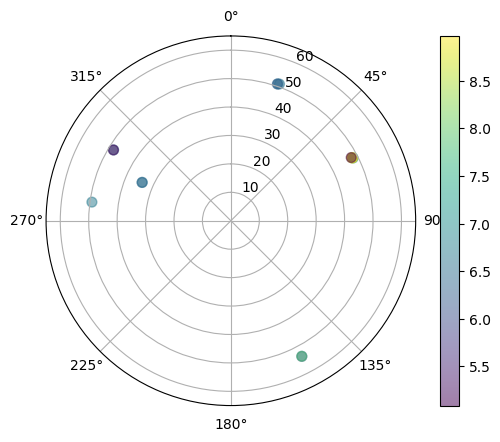

In [10]:
import matplotlib.pyplot as plt
import numpy as np


th = np.radians(xl)
r = 90 - np.array(yl)
val = np.array(cl)

fig, ax = plt.subplots(subplot_kw={"projection":"polar"})
c = ax.scatter(th,r,c=val, s=50,alpha=0.5)


ax.set_ylim(0,65)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

fig.colorbar(c, ax=ax)

plt.show()